In [418]:
import pandas as pd

frame = pd.read_csv('titanic.csv')
frame.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [419]:
frame.where(pd.notnull(frame['boat']))['survived'].value_counts()

1.0    477
0.0      9
Name: survived, dtype: int64

In [420]:
frame['survived'].value_counts(normalize=True)

0    0.618029
1    0.381971
Name: survived, dtype: float64

In [421]:
frame.dropna(subset=['pclass','sex','embarked'], axis=0, inplace=True)
#frame.replace(to_replace=pd.notnull(frame['boat']), value=999, inplace=True)
frame['boat'].fillna(value=-999,inplace=True)

frame.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,-999,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,-999,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,-999,NaN,"Montreal, PQ / Chesterville, ON"


In [422]:
frame['boat'].value_counts()

-999       823
13          39
C           38
15          37
14          33
4           31
10          29
5           27
3           26
11          25
9           25
7           23
16          23
8           23
D           20
12          19
6           18
2           13
A           11
B            9
1            5
13 15        2
5 7          2
C D          2
13 15 B      1
8 10         1
5 9          1
15 16        1
Name: boat, dtype: int64

In [423]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [424]:
from sklearn.ensemble import RandomForestClassifier

In [425]:
clf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, max_depth=5, bootstrap=True)

In [459]:
from sklearn.base import TransformerMixin
import numpy as np

class DataFrameImputer(TransformerMixin):

    def __init__(self, replace_value):
        self.replace_value = replace_value
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return np.nan_to_num(X, copy=True)

class DataTypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.astype(self.dtype)
class Replacement(BaseEstimator, TransformerMixin):
    def __init__(self, lookfor, replacement):
        self.lookfor = lookfor
        self.replacement = replacement
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X[X==self.lookfor] = self.replacement
        return X
class CabinReplacement(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X[X=='A'] = 100
        X[X=='B'] = 200
        X[X=='C'] = 300
        X[X=='D'] = 400
        X[X=='E'] = 500
        X[X=='F'] = 600
        X[X=='G'] = 700
        X[X=='T'] = 800
        X[X=='n'] = -999
        X[X=='-'] = -999
        return X

In [460]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer
cat_pipe_train = Pipeline([
    ('selector', DataFrameSelector(['pclass','sex','embarked'])),
    ('encoder', OneHotEncoder(sparse=False))
])

cabin_pipe_train = Pipeline([
    ('selector', DataFrameSelector(['cabin'])),
    ('replacement', Replacement(np.nan,'-1')),
    ('converter', DataTypeConverter('<U1')),
    ('cabin_replace', CabinReplacement())
])

num_pipe_train = Pipeline([
    ('selector', DataFrameSelector(['age','sibsp','parch','fare'])),
    ('imputer', SimpleImputer(strategy='median'))
])

from sklearn.pipeline import FeatureUnion

full_pipeline_train = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipe_train),
    ('cat_pipeline', cat_pipe_train),
    ('cabin_pipeline', cabin_pipe_train),
    
])

In [461]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer
cat_pipe = Pipeline([
    ('selector', DataFrameSelector(['Pclass','Sex','Embarked'])),
    ('encoder', OneHotEncoder(sparse=False))
])

cabin_pipe = Pipeline([
    ('selector', DataFrameSelector(['Cabin'])),
    ('replacement', Replacement(np.nan,'-1')),
    ('converter', DataTypeConverter('<U1')),
    ('cabin_replace', CabinReplacement())
])

num_pipe = Pipeline([
    ('selector', DataFrameSelector(['Age','SibSp','Parch','Fare'])),
    ('imputer', SimpleImputer(strategy='median'))
])

In [462]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipe),
    ('cat_pipeline', cat_pipe),
    ('cabin_pipeline', cabin_pipe),
    
])

In [463]:
frame.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,-999,NaN
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,-999,135.0
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,-999,NaN


In [464]:
pd.unique(frame['boat'])

array(['2', '11', -999, '3', '10', 'D', '4', '9', '6', 'B', '8', 'A', '5',
       '7', 'C', '14', '5 9', '13', '1', '15', '5 7', '8 10', '12', '16',
       '13 15 B', 'C D', '15 16', '13 15'], dtype=object)

In [465]:
y = frame['survived']
#frame.drop('home.dest', axis=1, inplace=True)
titanic_x = full_pipeline_train.fit_transform(frame.drop('survived', axis=1))
feature_names = ['Age','SibSp','Parch','Fare','first_class','second_class','third_class',
                 'female','male','Southhampton','Cherbourg','Queenstown', 'Floor']
print(len(feature_names),titanic_x[0].dtype)
titanic_df = pd.DataFrame(titanic_x, columns=feature_names)
titanic_df.head()

13 <U32


,Age,SibSp,Parch,Fare,first_class,second_class,third_class,female,male,Southhampton,Cherbourg,Queenstown,Floor
0,29.0,0.0,0.0,211.3375,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2
1,0.9167,1.0,2.0,151.55,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3
2,2.0,1.0,2.0,151.55,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3
3,30.0,1.0,2.0,151.55,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3
4,25.0,1.0,2.0,151.55,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3


In [466]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(titanic_x, y, test_size=0.2, shuffle=False)
x_train[0]

array(['29.0', '0.0', '0.0', '211.3375', '1.0', '0.0', '0.0', '1.0',
       '0.0', '0.0', '0.0', '1.0', '2'], dtype='<U32')

In [467]:
np.unique(x_train)

array(['-', '0.0', '0.1667', '0.3333', '0.6667', '0.75', '0.8333',
       '0.9167', '1', '1.0', '10.0', '10.1708', '10.5', '10.5167',
       '10.7083', '106.425', '108.9', '11.0', '11.1333', '11.5',
       '110.8833', '113.275', '12.0', '12.1833', '12.275', '12.2875',
       '12.35', '12.475', '12.525', '12.65', '12.7375', '12.875', '120.0',
       '13.0', '13.4167', '13.5', '13.7917', '13.8583', '13.8625', '13.9',
       '133.65', '134.5', '135.6333', '136.7792', '14.0', '14.1083',
       '14.4', '14.4542', '14.4583', '14.5', '146.5208', '15.0',
       '15.0333', '15.0458', '15.05', '15.1', '15.2458', '15.5', '15.55',
       '15.5792', '15.75', '15.85', '15.9', '151.55', '153.4625', '16.0',
       '16.1', '164.8667', '17.0', '17.4', '17.8', '18.0', '18.5',
       '18.75', '18.7875', '19.0', '19.2583', '19.5', '19.9667', '2',
       '2.0', '20.0', '20.25', '20.5', '20.525', '20.575', '21.0',
       '211.3375', '211.5', '22.0', '22.025', '22.5', '22.525',
       '221.7792', '227.525', '

In [468]:
clf.fit(x_train, y_train)

ValueError: could not convert string to float: '-'

In [325]:
clf.oob_score_

0.7990430622009569

In [326]:
from sklearn.metrics import accuracy_score

predictions = clf.predict(x_test)

accuracy_score(y_test,predictions)

0.8053435114503816

In [334]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(clf, {'n_estimators':[125,150,175], 'max_depth':[6,7,8,9]}, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth

In [336]:
grid_search.best_params_

{'max_depth': 9, 'n_estimators': 125}

In [337]:
predictions = grid_search.best_estimator_.predict(x_test)
accuracy_score(y_test,predictions)

0.7748091603053435

In [338]:

#feature_names = ['age','sibsp','parch','fare',
#                 'female','male']
val = 0
for name, score in zip(feature_names,grid_search.best_estimator_.feature_importances_):
    val += score
    print(name,score)
val

Age 0.15813902090840481
SibSp 0.0398846232353961
Parch 0.03698677573479054
Fare 0.15995201366273235
first_class 0.030852146453058473
second_class 0.019759288594887923
third_class 0.04040130668289237
female 0.19554070739157017
male 0.2185710210951957
Southhampton 0.015618020844651343
Cherbourg 0.005886207785159435
Queenstown 0.011608696458470598
A 0.0041999825299798
B 0.004575758608188213
C 0.007434026194027689
D 0.005861457944109825
E 0.008203916639809072
F 0.003210065877529966
G 0.0
H 0.0003037669757721923
- 0.03301119638337342


0.9999999999999999

NameError: name 'plt' is not defined

([<matplotlib.patches.Wedge at 0x144baf60d68>,
 [Text(0.9670190549246823, 0.5242844146191783, 'Age'),
  Text(0.48032170249329115, 0.9895913611758879, 'SibSp'),
  Text(0.22971436493558856, 1.0757468617394332, 'Parch'),
  Text(-0.43677657978147855, 1.009567342654463, 'Fare'),
  Text(-0.930196734056074, 0.5871405589391809, 'first_class'),
  Text(-1.0114260467969811, 0.4324550287146988, 'second_class'),
  Text(-1.0746634658963772, 0.23473055844432894, 'third_class'),
  Text(-0.9512003018337822, -0.5524653706716122, 'female'),
  Text(0.2789202275430221, -1.0640505188511253, 'male'),
  Text(0.9208875911329341, -0.6016361396204372, 'Southhampton'),
  Text(0.959401054728221, -0.5380981473545299, 'Cherbourg'),
  Text(0.9875123259474784, -0.4845816815582296, 'Queenstown'),
  Text(1.0103512800391876, -0.43496010267974583, 'A'),
  Text(1.0219575692293255, -0.40694314921729385, 'B'),
  Text(1.0365805182948702, -0.36810437255150685, 'C'),
  Text(1.0510472947210183, -0.3244989742042785, 'D'),
  Text(

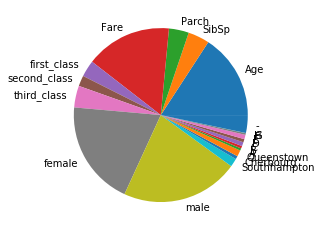

In [339]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.pie(grid_search.best_estimator_.feature_importances_,labels=feature_names)

<BarContainer object of 40 artists>

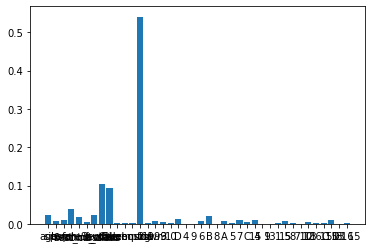

In [220]:
plt.bar(np.array(feature_names).astype(np.str), grid_search.best_estimator_.feature_importances_)

In [391]:
frame['survived'].value_counts()

0    809
1    498
Name: survived, dtype: int64

In [406]:

#frame['survived'].where(frame['sex']=='female').value_counts()


0        NaN
1       male
2        NaN
3        NaN
4        NaN
5       male
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14      male
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20      male
21       NaN
22      male
23       NaN
24       NaN
25       NaN
26      male
27       NaN
28       NaN
29      male
        ... 
1279     NaN
1280     NaN
1281     NaN
1282     NaN
1283     NaN
1284     NaN
1285     NaN
1286     NaN
1287     NaN
1288     NaN
1289     NaN
1290     NaN
1291     NaN
1292     NaN
1293     NaN
1294     NaN
1295     NaN
1296     NaN
1297     NaN
1298     NaN
1299     NaN
1300     NaN
1301     NaN
1302     NaN
1303     NaN
1304     NaN
1305     NaN
1306     NaN
1307     NaN
1308     NaN
Name: sex, Length: 1307, dtype: object

In [341]:
# Now time to create predictions to submit
frame = pd.read_csv('test.csv')
frame.head()
frame['Cabin'].value_counts()

B57 B59 B63 B66    3
B45                2
F4                 2
E34                2
A34                2
C116               2
C101               2
C23 C25 C27        2
C80                2
C89                2
C55 C57            2
C78                2
C31                2
C6                 2
F G63              1
B58 B60            1
B69                1
C39                1
B41                1
B11                1
C97                1
C105               1
C22 C26            1
E45                1
A21                1
D38                1
F33                1
D                  1
C132               1
D19                1
                  ..
D21                1
B24                1
E60                1
D40                1
E52                1
A9                 1
B61                1
E39 E41            1
B52 B54 B56        1
C7                 1
E50                1
C54                1
C85                1
D10 D12            1
B78                1
D22                1
B36          

In [346]:
titanic_val = full_pipeline.fit_transform(frame)

In [347]:
predictions = grid_search.best_estimator_.predict(titanic_val)

ValueError: Number of features of the model must match the input. Model n_features is 21 and input n_features is 20 

In [286]:
print('PassengerId,Survived')
[print('{},{}'.format(idnum,pred)) for idnum,pred in zip(frame['PassengerId'],predictions)]

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,0
900,1
901,0
902,0
903,0
904,1
905,0
906,1
907,1
908,0
909,0
910,0
911,1
912,0
913,1
914,1
915,1
916,1
917,0
918,1
919,0
920,0
921,0
922,0
923,0
924,1
925,0
926,1
927,0
928,0
929,0
930,0
931,1
932,1
933,0
934,0
935,1
936,1
937,0
938,0
939,0
940,1
941,1
942,0
943,0
944,1
945,1
946,0
947,0
948,0
949,0
950,0
951,1
952,0
953,0
954,0
955,1
956,1
957,1
958,0
959,0
960,0
961,1
962,1
963,0
964,0
965,0
966,1
967,0
968,0
969,1
970,0
971,1
972,0
973,0
974,0
975,0
976,0
977,0
978,1
979,1
980,1
981,1
982,1
983,0
984,1
985,0
986,0
987,0
988,1
989,0
990,0
991,0
992,1
993,0
994,0
995,0
996,1
997,0
998,0
999,0
1000,0
1001,0
1002,0
1003,1
1004,0
1005,0
1006,0
1007,0
1008,0
1009,1
1010,0
1011,1
1012,1
1013,0
1014,1
1015,0
1016,0
1017,1
1018,0
1019,1
1020,0
1021,0
1022,0
1023,0
1024,0
1025,0
1026,0
1027,0
1028,0
1029,0
1030,0
1031,0
1032,0
1033,1
1034,0
1035,0
1036,0
1037,0
1038,0
1039,0
1040,0
1041,0
1042,1
1043,0
1044,0
1045,0
1046,0
10

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,